

```
# author: puru panta (purupanta@uky.edu)
# date: 11/30/2024
# filename: PredictMLDL_Separate
```



In [1]:
!pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.2 MB/s eta 0:00:00


**STEP1: Load google-drive, and libraries**

In [2]:
# Mounting google drive if it is already not mounted
def LoadGoogleDrive(googleDriveDir):
  # Link Google Drive
  import os
  # Check if Google Drive is already mounted
  if not os.path.exists(googleDriveDir + "/MyDrive"):
      print("Mounting Google Drive...")
      from google.colab import drive
      drive.mount(googleDriveDir)
  else:
      print("Google Drive is already mounted!")

from google.colab import drive
googleDriveFolder = "/content/drive"
LoadGoogleDrive(googleDriveFolder)

Mounting Google Drive...
Mounted at /content/drive


In [3]:
import sys
import import_ipynb

# 1. Set path to the directory where mylib.ipynb is located
lib_path = '/content/drive/MyDrive/Colab Notebooks/P_HINTS6/lib'
sys.path.append(lib_path)
# 2. Change current working directory to that path
%cd "$lib_path"

# 3. Now import the notebook
from app_lib import *
from features_analysis import *

/content/drive/MyDrive/Colab Notebooks/P_HINTS6/lib


**STEP2: Load data**

In [4]:
ip_file_path = googleDriveFolder + "/MyDrive/Colab Notebooks/P_HINTS6/op_data/hints6_public_filtered_v2.xlsx"
ip_sheet_name = 'df_cleaned'
df_orig = load_data(verbose_level=1, ip_file_path=ip_file_path, ip_sheet_name=ip_sheet_name)

Ip File Path: /content/drive/MyDrive/Colab Notebooks/P_HINTS6/op_data/hints6_public_filtered_v2.xlsx
 SheetName: df_cleaned
df_orig.shape: (4865, 27)


In [5]:
# Copy of original DataFrame
df = df_orig.copy()

In [6]:
# Ignore missing codes like -9
counts = df.loc[df["MedConditions_HeartCondition"].isin([0, 1]), "MedConditions_HeartCondition"] \
            .value_counts().sort_index()

print("Counts for MedConditions_HeartCondition (only 0 and 1):")
print(counts)


Counts for MedConditions_HeartCondition (only 0 and 1):
MedConditions_HeartCondition
0    4412
1     453
Name: count, dtype: int64


**STEP3: Correlation Matrix**

/tmp/ipython-input-2085882560.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='Pearson Correlation', y='Feature', palette='coolwarm')


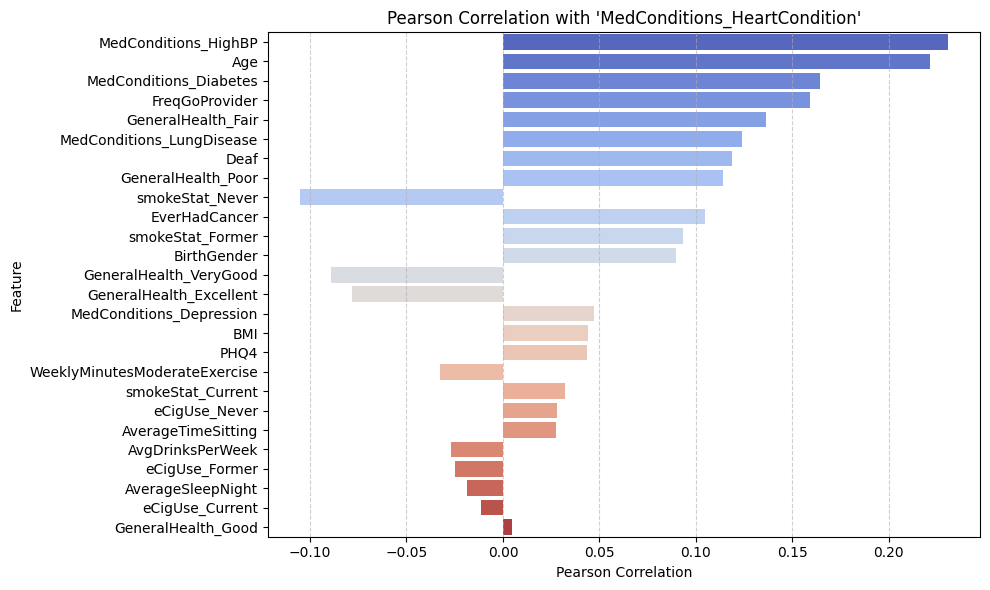

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Target column
target_col = 'MedConditions_HeartCondition'

# Calculate Pearson correlation of all features with the target
correlations = df.corr(method='pearson')[target_col].drop(target_col).sort_values(key=abs, ascending=False)

# Convert to DataFrame for easier plotting
corr_df = correlations.to_frame().reset_index()
corr_df.columns = ['Feature', 'Pearson Correlation']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x='Pearson Correlation', y='Feature', palette='coolwarm')
plt.title(f"Pearson Correlation with '{target_col}'")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


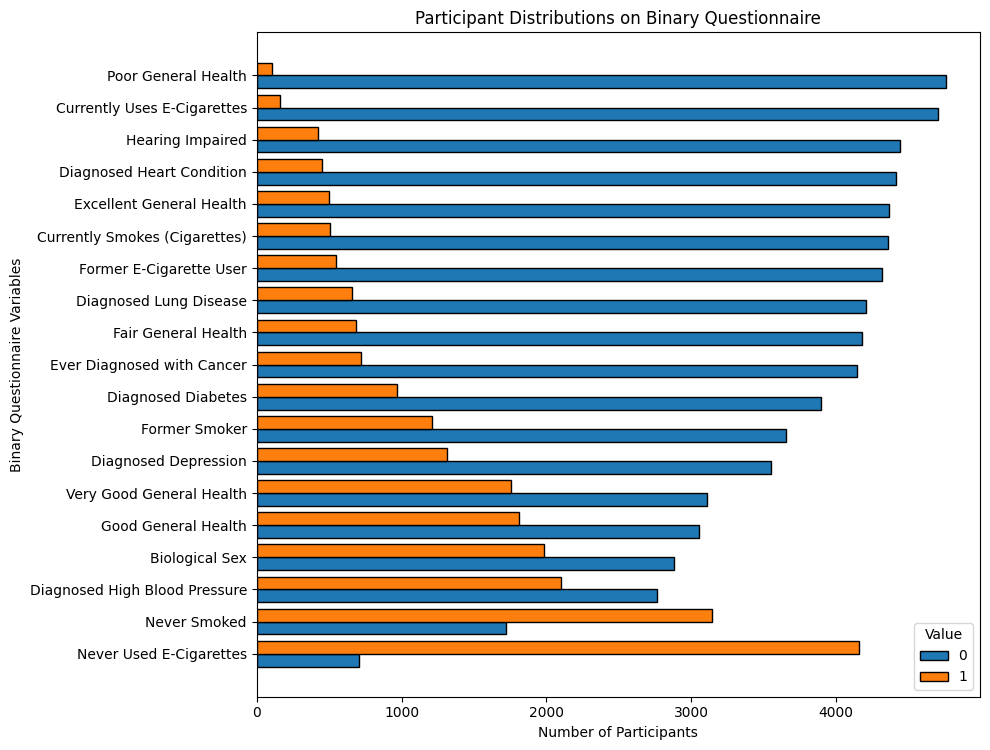

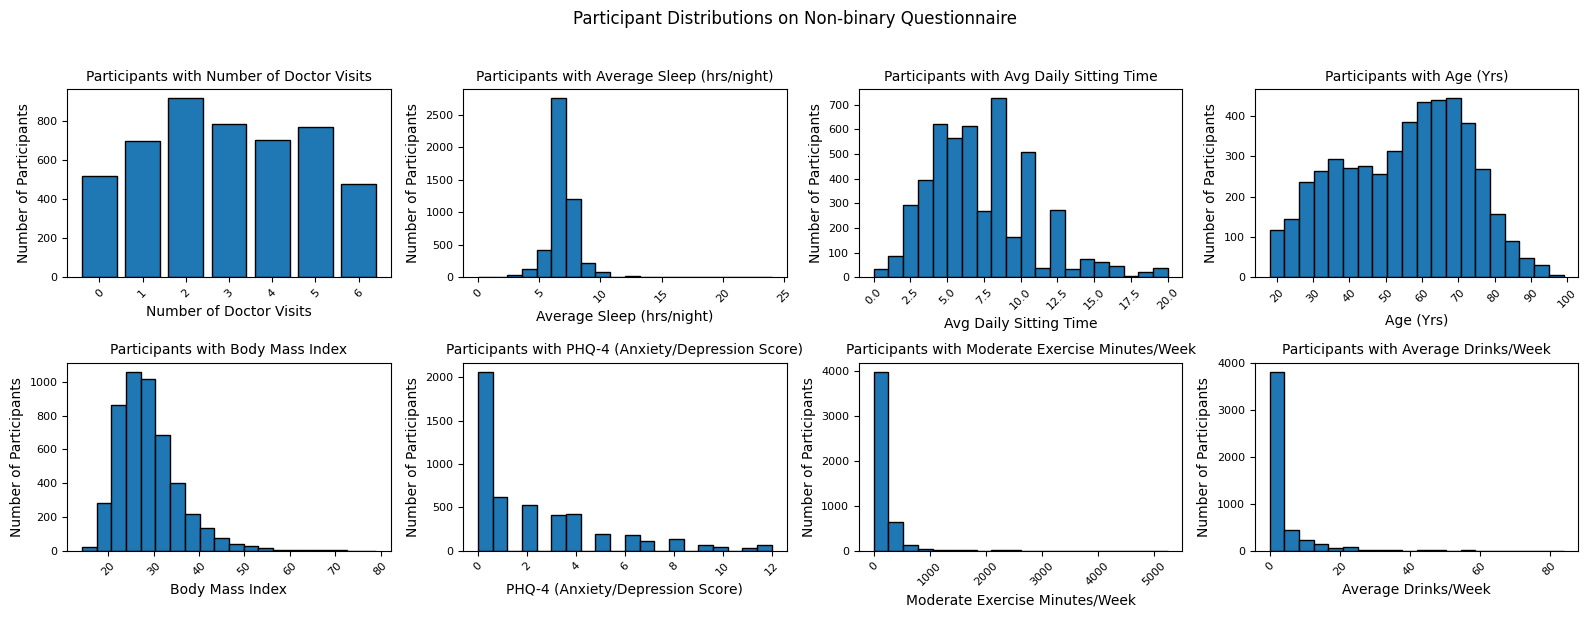

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# ----------------------------------
# Aliases
# ----------------------------------
# Assumes you provide: get_feature_alias_by_category() and df

# Flatten alias dictionary: var_name -> alias
alias_dict = {k: v for cat in get_feature_alias_by_category().values() for k, v in cat.items()}

# A helper that, given any column label (either original var or already-alias),
# returns the alias to display (defaulting to the input if unknown).
def to_alias(name: str) -> str:
    # If it's a known original variable name, return its alias
    if name in alias_dict:
        return alias_dict[name]
    # If it's already an alias (post-rename), keep it
    if name in alias_dict.values():
        return name
    # Fallback: use the name as-is
    return name

# ----------------------------------
# Optional: variable-specific axis overrides
# Keys can be *either* the original variable name or the alias; both are supported.
# ----------------------------------
plot_labels = {}

# Provide overrides with original variable names
plot_labels.update({
    "FreqGoProvider": {
        "title": "Participants with " + to_alias("FreqGoProvider"),
        "x": to_alias("FreqGoProvider"),
        "y": "Number of Participants"
      },
    "AverageSleepNight": {
        "title": "Participants with " + to_alias("AverageSleepNight"),
        "x": to_alias("AverageSleepNight"),
        "y": "Number of Participants"
      },
    "AverageTimeSitting": {
        "title": "Participants with " + to_alias("AverageTimeSitting"),
        "x": to_alias("AverageTimeSitting"),
        "y": "Number of Participants"
      },
    "Age": {
        "title": "Participants with " + to_alias("Age"),
        "x": to_alias("Age"),
        "y": "Number of Participants"
      },
    "BMI": {
        "title": "Participants with " + to_alias("BMI"),
        "x": to_alias("BMI"),
        "y": "Number of Participants"
      },
    "PHQ4": {
        "title": "Participants with " + to_alias("PHQ4"),
        "x": to_alias("PHQ4"),
        "y": "Number of Participants"
      },
    "WeeklyMinutesModerateExercise": {
        "title": "Participants with " + to_alias("WeeklyMinutesModerateExercise"),
        "x": to_alias("WeeklyMinutesModerateExercise"),
        "y": "Number of Participants",
    },
    "AvgDrinksPerWeek": {
        "title": "Participants with " + to_alias("AvgDrinksPerWeek"),
        "x": to_alias("AvgDrinksPerWeek"),
        "y": "Number of Participants"
      },
})

# Mirror the same overrides using alias keys as well (so it still works after renaming)
for var, alias in alias_dict.items():
    if var in plot_labels and alias not in plot_labels:
        plot_labels[alias] = plot_labels[var]

# Generic label resolver with robust fallbacks
def get_axis_labels(col: str):
    """
    Resolve per-plot labels with the following precedence:
      1) plot_labels override (by exact key match on col)
      2) title/x default to the alias of col (or col if unknown)
      3) y defaults to 'Number of participants' for non-binary and 'Count' when unspecified
    """
    override = plot_labels.get(col, {})
    title_label = override.get("title", to_alias(col))
    x_label = override.get("x", to_alias(col))
    y_label = override.get("y")  # may be None here; caller can set a default per context
    return title_label, x_label, y_label

# ----------------------------------
# Load / clean / rename
# ----------------------------------
df = df.replace(-9, np.nan)

# Rename columns using alias_dict (so df columns become aliases)
df.rename(columns={col: alias_dict[col] for col in df.columns if col in alias_dict}, inplace=True)

# ----------------------------------
# Binary detector (robust to bool dtype)
# ----------------------------------
def is_strict_binary(series: pd.Series) -> bool:
    s = series.dropna()
    if s.empty:
        return False
    # Normalize booleans to integers for membership test
    def _norm(v):
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        return v
    vals = set(map(_norm, s.unique()))
    return vals.issubset({0, 1}) and len(vals) > 0

binary_vars = [c for c in df.columns if is_strict_binary(df[c])]
nonbinary_vars = [c for c in df.columns if c not in binary_vars]

# -------------------
# 1) Binary plots
# -------------------
if binary_vars:
    counts0 = [(df[c] == 0).sum() for c in binary_vars]
    counts1 = [(df[c] == 1).sum() for c in binary_vars]
    order = np.argsort(-np.array(counts1))
    binary_vars_sorted = [binary_vars[i] for i in order]
    counts0_sorted = [counts0[i] for i in order]
    counts1_sorted = [counts1[i] for i in order]

    y = np.arange(len(binary_vars_sorted))
    bar_h = 0.4

    plt.figure(figsize=(10, max(4, 0.4 * len(binary_vars_sorted))))
    plt.barh(y - bar_h / 2, counts0_sorted, height=bar_h, edgecolor="black", label="0")
    plt.barh(y + bar_h / 2, counts1_sorted, height=bar_h, edgecolor="black", label="1")

    # Labels
    # For binary overview, use a consistent y-axis label; x is count of participants.
    plt.xlabel("Number of Participants")
    plt.ylabel("Binary Questionnaire Variables")
    # Titles shown on the y-tick labels (per variable)
    plt.yticks(y, [get_axis_labels(var)[0] for var in binary_vars_sorted])

    plt.title("Participant Distributions on Binary Questionnaire")
    plt.legend(title="Value")
    plt.tight_layout()
    plt.show()

# -------------------
# 2) Non-binary grid
# -------------------
if nonbinary_vars:
    CAT_CUTOFF = 10
    n = len(nonbinary_vars)
    N_COLS = 4
    N_ROWS = math.ceil(n / N_COLS)

    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 4, N_ROWS * 3))
    axes = axes.flatten()

    for i, col in enumerate(nonbinary_vars):
        ax = axes[i]
        s = df[col].dropna()

        title_label, x_label, y_label = get_axis_labels(col)
        # Default y-label for non-binary plots if not overridden
        if y_label is None:
            y_label = "Number of Participants"

        if s.nunique() <= CAT_CUTOFF:
            counts = s.value_counts().sort_index()
            ax.bar(counts.index.astype(str), counts.values, edgecolor="black")
        else:
            # Numeric histogram
            s_num = pd.to_numeric(s, errors="coerce").dropna()
            ax.hist(s_num, bins=20, edgecolor="black")

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title_label, fontsize=10)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

    # Remove unused axes (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Participant Distributions on Non-binary Questionnaire", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


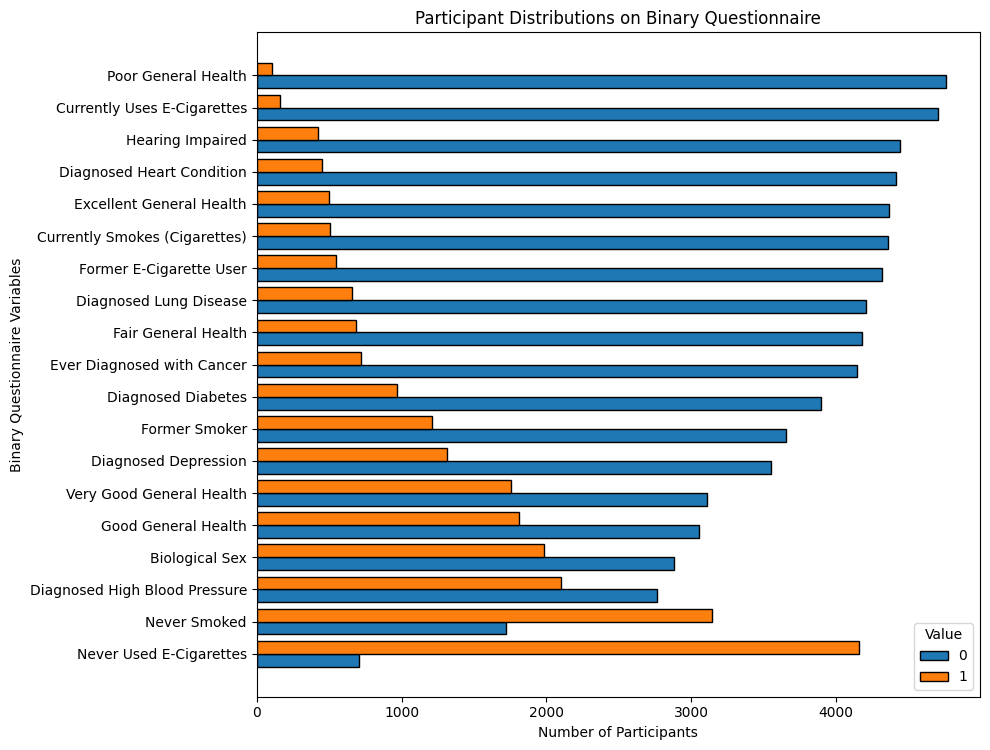

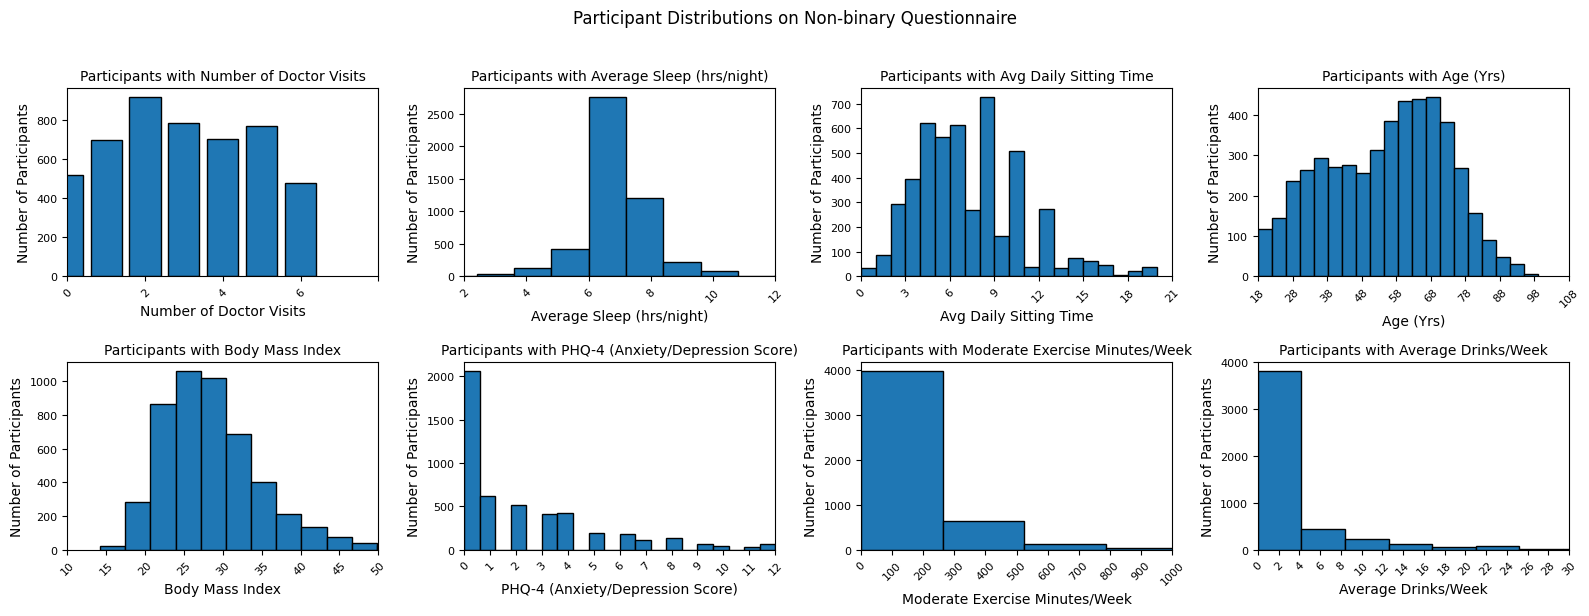

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MultipleLocator

# ----------------------------------
# Aliases
# ----------------------------------
alias_dict = {k: v for cat in get_feature_alias_by_category().values() for k, v in cat.items()}

def to_alias(name: str) -> str:
    if name in alias_dict:
        return alias_dict[name]
    if name in alias_dict.values():
        return name
    return name

# ----------------------------------
# Variable-specific overrides with xlim and xticks_interval for each
# ----------------------------------
plot_labels = {
    "FreqGoProvider": {
        "title": "Participants with " + to_alias("FreqGoProvider"),
        "x": to_alias("FreqGoProvider"),
        "y": "Number of Participants",
        "xlim": (0, 8),
        "xticks_interval": 2
    },
    "AverageSleepNight": {
        "title": "Participants with " + to_alias("AverageSleepNight"),
        "x": to_alias("AverageSleepNight"),
        "y": "Number of Participants",
        "xlim": (2, 12),
        "xticks_interval": 2
    },
    "AverageTimeSitting": {
        "title": "Participants with " + to_alias("AverageTimeSitting"),
        "x": to_alias("AverageTimeSitting"),
        "y": "Number of Participants",
        "xlim": (0, 20),
        "xticks_interval": 3
    },
    "Age": {
        "title": "Participants with " + to_alias("Age"),
        "x": to_alias("Age"),
        "y": "Number of Participants",
        "xlim": (18, 99),
        "xticks_interval": 10
    },
    "BMI": {
        "title": "Participants with " + to_alias("BMI"),
        "x": to_alias("BMI"),
        "y": "Number of Participants",
        "xlim": (10, 50),
        "xticks_interval": 5
    },
    "PHQ4": {
        "title": "Participants with " + to_alias("PHQ4"),
        "x": to_alias("PHQ4"),
        "y": "Number of Participants",
        "xlim": (0, 12),
        "xticks_interval": 1
    },
    "WeeklyMinutesModerateExercise": {
        "title": "Participants with " + to_alias("WeeklyMinutesModerateExercise"),
        "x": to_alias("WeeklyMinutesModerateExercise"),
        "y": "Number of Participants",
        "xlim": (0, 1000),
        "xticks_interval": 100
    },
    "AvgDrinksPerWeek": {
        "title": "Participants with " + to_alias("AvgDrinksPerWeek"),
        "x": to_alias("AvgDrinksPerWeek"),
        "y": "Number of Participants",
        "xlim": (0, 30),
        "xticks_interval": 2
    },
}

# Mirror overrides for alias keys as well
for var, alias in alias_dict.items():
    if var in plot_labels and alias not in plot_labels:
        plot_labels[alias] = plot_labels[var]

def get_axis_labels(col: str):
    override = plot_labels.get(col, {})
    title_label = override.get("title", to_alias(col))
    x_label = override.get("x", to_alias(col))
    y_label = override.get("y")
    return title_label, x_label, y_label

# ----------------------------------
# Load / clean / rename
# ----------------------------------
df = df.replace(-9, np.nan)
df.rename(columns={col: alias_dict[col] for col in df.columns if col in alias_dict}, inplace=True)

# ----------------------------------
# Binary detector
# ----------------------------------
def is_strict_binary(series: pd.Series) -> bool:
    s = series.dropna()
    if s.empty:
        return False
    def _norm(v):
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        return v
    vals = set(map(_norm, s.unique()))
    return vals.issubset({0, 1}) and len(vals) > 0

binary_vars = [c for c in df.columns if is_strict_binary(df[c])]
nonbinary_vars = [c for c in df.columns if c not in binary_vars]

# -------------------
# 1) Binary plots
# -------------------
if binary_vars:
    counts0 = [(df[c] == 0).sum() for c in binary_vars]
    counts1 = [(df[c] == 1).sum() for c in binary_vars]
    order = np.argsort(-np.array(counts1))
    binary_vars_sorted = [binary_vars[i] for i in order]
    counts0_sorted = [counts0[i] for i in order]
    counts1_sorted = [counts1[i] for i in order]

    y = np.arange(len(binary_vars_sorted))
    bar_h = 0.4

    plt.figure(figsize=(10, max(4, 0.4 * len(binary_vars_sorted))))
    plt.barh(y - bar_h / 2, counts0_sorted, height=bar_h, edgecolor="black", label="0")
    plt.barh(y + bar_h / 2, counts1_sorted, height=bar_h, edgecolor="black", label="1")

    plt.xlabel("Number of Participants")
    plt.ylabel("Binary Questionnaire Variables")
    plt.yticks(y, [get_axis_labels(var)[0] for var in binary_vars_sorted])

    plt.title("Participant Distributions on Binary Questionnaire")
    plt.legend(title="Value")
    plt.tight_layout()
    plt.show()

# -------------------
# 2) Non-binary grid with xlim & xticks_interval applied
# -------------------
if nonbinary_vars:
    CAT_CUTOFF = 10
    n = len(nonbinary_vars)
    N_COLS = 4
    N_ROWS = math.ceil(n / N_COLS)

    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 4, N_ROWS * 3))
    axes = axes.flatten()

    for i, col in enumerate(nonbinary_vars):
        ax = axes[i]
        s = df[col].dropna()

        override = plot_labels.get(col, {})
        title_label, x_label, y_label = get_axis_labels(col)
        if y_label is None:
            y_label = "Number of Participants"

        if s.nunique() <= CAT_CUTOFF or not pd.api.types.is_numeric_dtype(s):
            counts = s.value_counts(dropna=False).sort_index()
            ax.bar(counts.index.astype(str), counts.values, edgecolor="black")
        else:
            s_num = pd.to_numeric(s, errors="coerce").dropna()
            bins = int(override.get("bins", 20))
            density = bool(override.get("density", False))
            ax.hist(s_num, bins=bins, density=density, edgecolor="black")

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title_label, fontsize=10)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        # Apply xlim and xticks_interval from overrides
        if "xlim" in override:
            ax.set_xlim(*override["xlim"])
            if "xticks_interval" in override:
                start, end = override["xlim"]
                step = override["xticks_interval"]
                ax.set_xticks(np.arange(start, end + step, step))
        if "ylim" in override:
            ax.set_ylim(*override["ylim"])
        if "xscale" in override:
            ax.set_xscale(override["xscale"])
        if "yscale" in override:
            ax.set_yscale(override["yscale"])

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Participant Distributions on Non-binary Questionnaire", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


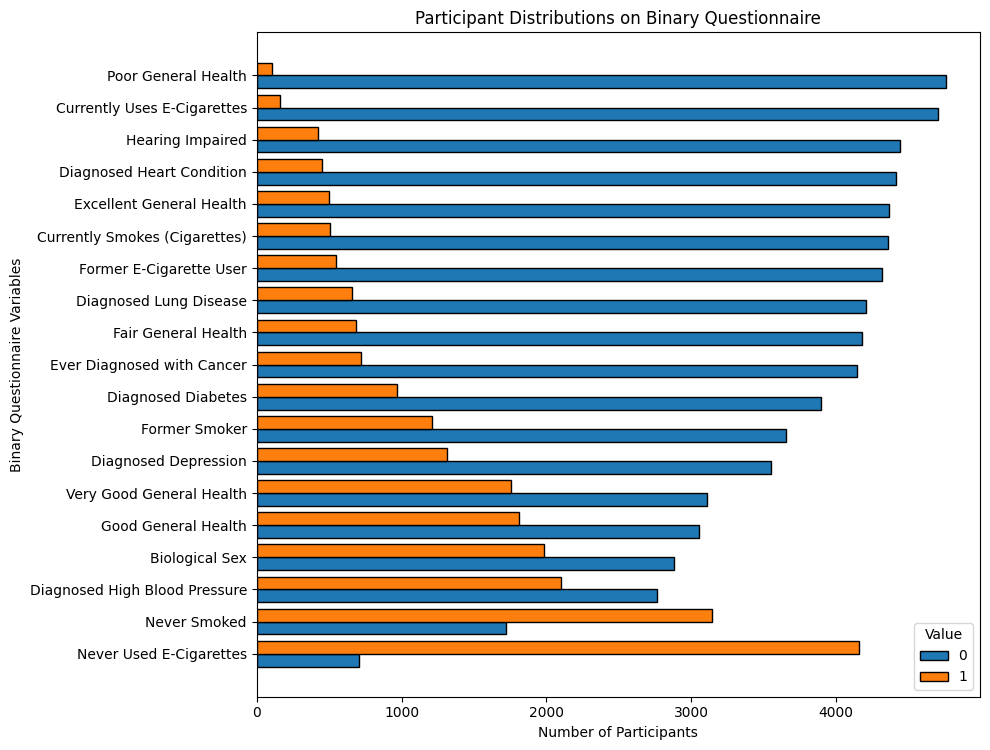

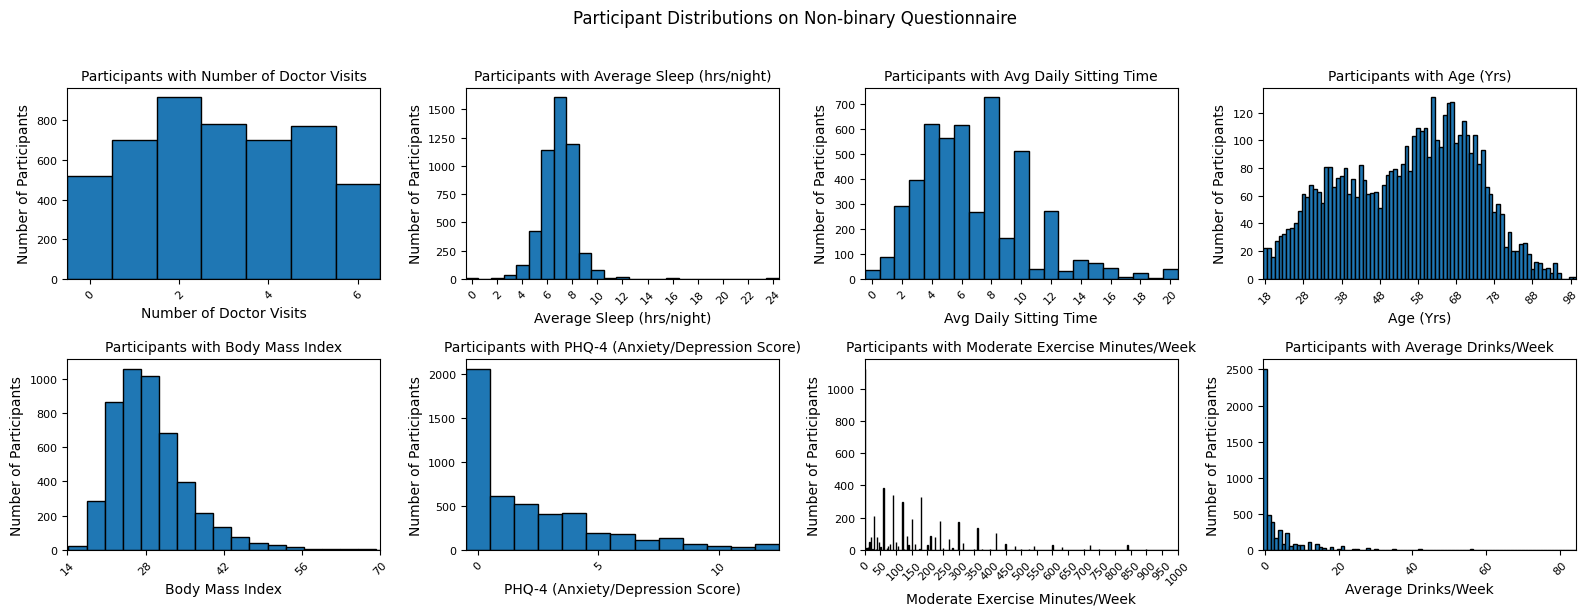

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MultipleLocator

# ----------------------------------
# Assumptions: you provide df and get_feature_alias_by_category()
# ----------------------------------

# Flatten alias dictionary: original_var_name -> alias
alias_dict = {k: v for cat in get_feature_alias_by_category().values() for k, v in cat.items()}

def to_alias(name: str) -> str:
    """Return display alias for a variable name (idempotent if already an alias)."""
    if name in alias_dict:
        return alias_dict[name]
    if name in alias_dict.values():
        return name
    return name

# ----------------------------------
# Per-variable display/axis overrides
# Each entry includes explicit xlim and xticks_interval as requested.
# Adjust the numeric values as appropriate for your data.
# ----------------------------------
plot_labels = {
    "FreqGoProvider": {
        "title": "Participants with " + to_alias("FreqGoProvider"),
        "x": to_alias("FreqGoProvider"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("FreqGoProvider")].min(), df[to_alias("FreqGoProvider")].max()),
        "xticks_interval": 2
    },
    "AverageSleepNight": {
        "title": "Participants with " + to_alias("AverageSleepNight"),
        "x": to_alias("AverageSleepNight"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("AverageSleepNight")].min(), df[to_alias("AverageSleepNight")].max()),
        "xticks_interval": 2
    },
    "AverageTimeSitting": {
        "title": "Participants with " + to_alias("AverageTimeSitting"),
        "x": to_alias("AverageTimeSitting"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("AverageTimeSitting")].min(), df[to_alias("AverageTimeSitting")].max()),
        "xticks_interval": 2
    },
    "Age": {
        "title": "Participants with " + to_alias("Age"),
        "x": to_alias("Age"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("Age")].min(), df[to_alias("Age")].max()),
        "xticks_interval": 10
    },
    "BMI": {
        "title": "Participants with " + to_alias("BMI"),
        "x": to_alias("BMI"),
        "y": "Number of Participants",
        # "xlim": (df[to_alias("BMI")].min(), df[to_alias("BMI")].max()),
        "xlim": (14, 70),
        "xticks_interval": 14
    },
    "PHQ4": {
        "title": "Participants with " + to_alias("PHQ4"),
        "x": to_alias("PHQ4"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("PHQ4")].min(), df[to_alias("PHQ4")].max()),
        "xticks_interval": 5
    },
    "WeeklyMinutesModerateExercise": {
        "title": "Participants with " + to_alias("WeeklyMinutesModerateExercise"),
        "x": to_alias("WeeklyMinutesModerateExercise"),
        "y": "Number of Participants",
        # "xlim": (df[to_alias("WeeklyMinutesModerateExercise")].min(), df[to_alias("WeeklyMinutesModerateExercise")].max()),
        "xlim": (0, 1000),
        "xticks_interval": 50
    },
    "AvgDrinksPerWeek": {
        "title": "Participants with " + to_alias("AvgDrinksPerWeek"),
        "x": to_alias("AvgDrinksPerWeek"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("AvgDrinksPerWeek")].min(), df[to_alias("AvgDrinksPerWeek")].max()),
        "xticks_interval": 20
    },
}

# Mirror overrides onto alias keys as well (so they still apply post-rename)
for _var, _alias in alias_dict.items():
    if _var in plot_labels and _alias not in plot_labels:
        plot_labels[_alias] = plot_labels[_var]

def get_axis_labels(col: str):
    """Resolve per-plot labels and defaults."""
    override = plot_labels.get(col, {})
    title_label = override.get("title", to_alias(col))
    x_label     = override.get("x", to_alias(col))
    y_label     = override.get("y")  # may be None; caller sets fallback
    return title_label, x_label, y_label, override

# ----------------------------------
# Cleaning / renaming
# ----------------------------------
df = df.replace(-9, np.nan)
df.rename(columns={c: alias_dict[c] for c in df.columns if c in alias_dict}, inplace=True)

# ----------------------------------
# Helpers
# ----------------------------------
def is_strict_binary(series: pd.Series) -> bool:
    """Binary if values subset of {0,1} after dropping NA (bools allowed)."""
    s = series.dropna()
    if s.empty:
        return False
    def _norm(v):
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        return v
    vals = set(map(_norm, s.unique()))
    return vals.issubset({0, 1}) and len(vals) > 0

def is_integer_like_numeric(series: pd.Series, tol: float = 1e-9) -> bool:
    """
    True if numeric and all finite values are (within tol) integers.
    This is used to switch to integer-centered histogram bins (touching bars).
    """
    if not pd.api.types.is_numeric_dtype(series):
        return False
    s_num = pd.to_numeric(series, errors="coerce").dropna().values
    if s_num.size == 0:
        return False
    return np.all(np.isfinite(s_num)) and np.all(np.abs(s_num - np.round(s_num)) <= tol)

def nice_step(span: float) -> float:
    """A 'nice' step size given a span (≈6 ticks target)."""
    if span <= 0 or not np.isfinite(span):
        return 1.0
    raw = span / 6.0
    exp = math.floor(math.log10(raw))
    frac = raw / (10 ** exp)
    if frac < 1.5:
        nice = 1.0
    elif frac < 3:
        nice = 2.0
    elif frac < 7:
        nice = 5.0
    else:
        nice = 10.0
    return nice * (10 ** exp)

# ----------------------------------
# Partition variables
# ----------------------------------
binary_vars    = [c for c in df.columns if is_strict_binary(df[c])]
nonbinary_vars = [c for c in df.columns if c not in binary_vars]

# -------------------
# 1) Binary plots
# -------------------
if binary_vars:
    counts0 = [(df[c] == 0).sum() for c in binary_vars]
    counts1 = [(df[c] == 1).sum() for c in binary_vars]
    order = np.argsort(-np.array(counts1))
    binary_vars_sorted = [binary_vars[i] for i in order]
    counts0_sorted = [counts0[i] for i in order]
    counts1_sorted = [counts1[i] for i in order]

    y = np.arange(len(binary_vars_sorted))
    bar_h = 0.4

    plt.figure(figsize=(10, max(4, 0.4 * len(binary_vars_sorted))))
    plt.barh(y - bar_h/2, counts0_sorted, height=bar_h, edgecolor="black", label="0")
    plt.barh(y + bar_h/2, counts1_sorted, height=bar_h, edgecolor="black", label="1")

    plt.xlabel("Number of Participants")
    plt.ylabel("Binary Questionnaire Variables")
    plt.yticks(y, [get_axis_labels(var)[0] for var in binary_vars_sorted])
    plt.title("Participant Distributions on Binary Questionnaire")
    plt.legend(title="Value")
    plt.tight_layout()
    plt.show()

# -------------------
# 2) Non-binary grid
#    FIX: integer-like numeric variables plotted with *adjacent* integer bins
#         (no gaps). Categorical bars use width=1.0 to minimize spaces.
# -------------------
if nonbinary_vars:
    CAT_CUTOFF = 10
    n = len(nonbinary_vars)
    N_COLS = 4
    N_ROWS = math.ceil(n / N_COLS)

    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 4, N_ROWS * 3))
    axes = axes.flatten()

    for i, col in enumerate(nonbinary_vars):
        ax = axes[i]
        s = df[col].dropna()
        title_label, x_label, y_label, override = get_axis_labels(col)
        if y_label is None:
            y_label = "Number of Participants"

        # Determine plotting mode
        numeric_dtype = pd.api.types.is_numeric_dtype(s)
        integer_like  = is_integer_like_numeric(s)

        if (not numeric_dtype) or (s.nunique() <= CAT_CUTOFF and not integer_like):
            # Categorical bar chart
            counts = s.astype(str).value_counts(dropna=False).sort_index()
            # width=1.0 reduces perceived gaps between categories
            ax.bar(counts.index, counts.values, width=1.0, edgecolor="black")

            # Optional categorical x-limits/ticks if user provided numeric-like bounds
            if "xlim" in override:
                ax.set_xlim(*override["xlim"])
            if "xticks_interval" in override and "xlim" in override:
                start, end = override["xlim"]
                step = override["xticks_interval"]
                if step > 0:
                    ax.set_xticks(np.arange(start, end + step, step))

        else:
            # Numeric histogram
            s_num = pd.to_numeric(s, errors="coerce").dropna()

            if integer_like:
                # Integer-centered bins: edges at k-0.5 ... k+0.5, bars touch (no gaps)
                xmin = int(np.floor(s_num.min()))
                xmax = int(np.ceil(s_num.max()))
                # If user provided xlim, honor it for bins/ticks; else use data range
                if "xlim" in override:
                    xmin, xmax = int(override["xlim"][0]), int(override["xlim"][1])
                bin_edges = np.arange(xmin - 0.5, xmax + 1.5, 1.0)
                ax.hist(s_num, bins=bin_edges, edgecolor="black")

                # X limits and ticks
                ax.set_xlim(xmin - 0.5, xmax + 0.5)
                step = override.get("xticks_interval", 1)
                step = step if step and step > 0 else 1
                ax.set_xticks(np.arange(xmin, xmax + 1, step))

            else:
                # Continuous numeric: standard histogram
                bins = int(override.get("bins", 20))
                ax.hist(s_num, bins=bins, edgecolor="black")

                # Apply optional numeric xlim and ticks
                if "xlim" in override:
                    xmin, xmax = override["xlim"]
                    ax.set_xlim(xmin, xmax)
                    step = override.get("xticks_interval", None)
                    if step and step > 0:
                        ax.xaxis.set_major_locator(MultipleLocator(step))
                        ax.set_xticks(np.arange(xmin, xmax + step, step))
                else:
                    # Compute a "nice" tick step if interval not specified
                    xmin, xmax = float(s_num.min()), float(s_num.max())
                    span = xmax - xmin
                    step = override.get("xticks_interval", None)
                    if step is None:
                        step = nice_step(span)
                    ax.xaxis.set_major_locator(MultipleLocator(step))

        # Labels, titles, cosmetics
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title_label, fontsize=10)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        # Optional y-axis setup (applies to both categorical and numeric)
        if "ylim" in override:
            ax.set_ylim(*override["ylim"])
        if "xscale" in override:
            ax.set_xscale(override["xscale"])
        if "yscale" in override:
            ax.set_yscale(override["yscale"])

    # Remove unused axes (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Participant Distributions on Non-binary Questionnaire", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


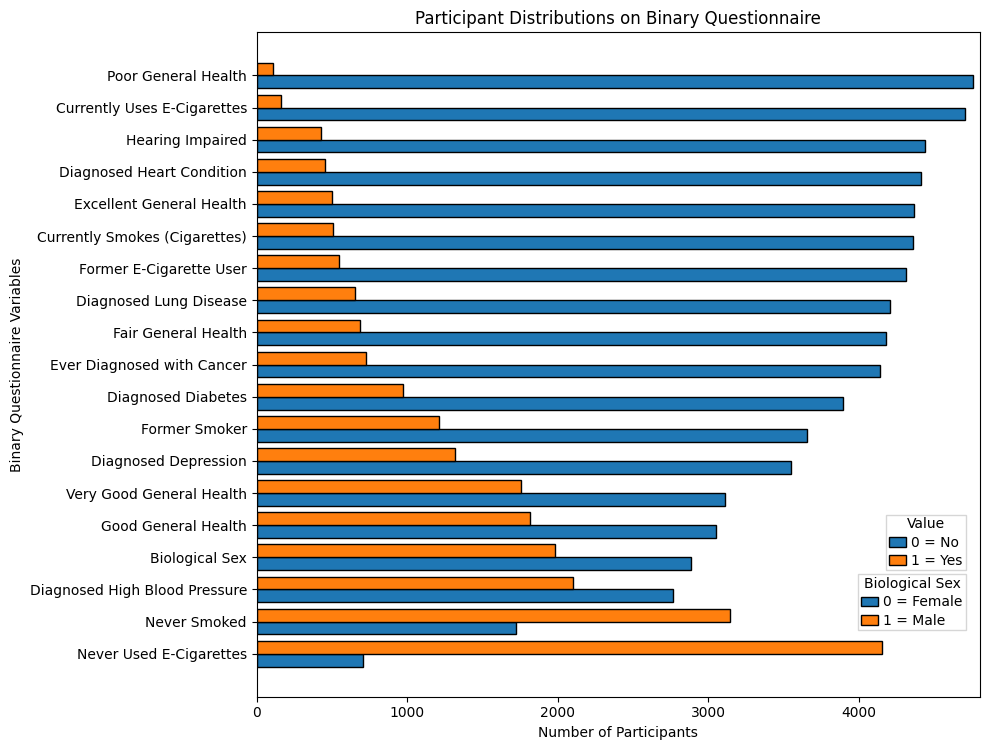

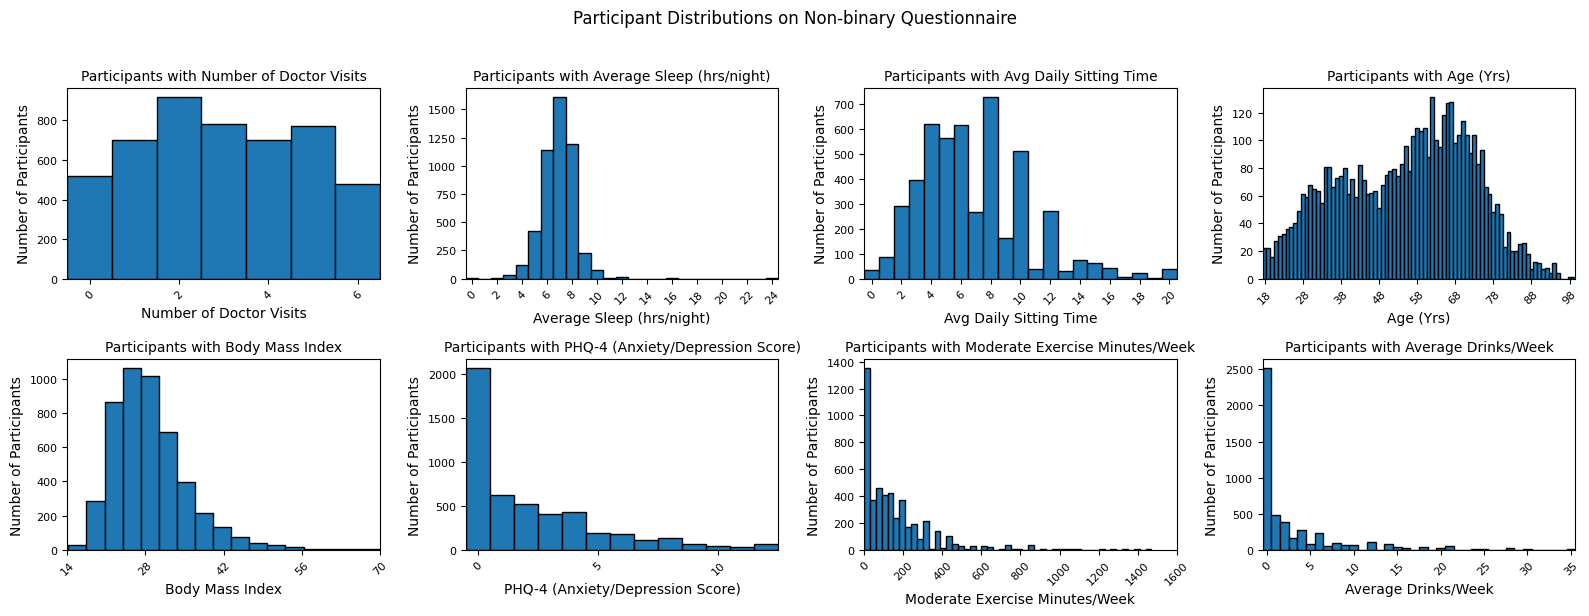

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches  # for manual legend entries

# ----------------------------------
# Assumptions: you provide df and get_feature_alias_by_category()
# ----------------------------------

# Flatten alias dictionary: original_var_name -> alias
alias_dict = {k: v for cat in get_feature_alias_by_category().values() for k, v in cat.items()}

def to_alias(name: str) -> str:
    """Return display alias for a variable name (idempotent if already an alias)."""
    if name in alias_dict:
        return alias_dict[name]
    if name in alias_dict.values():
        return name
    return name

# ----------------------------------
# Cleaning / renaming  (BEFORE plot_labels)
# ----------------------------------
df = df.replace(-9, np.nan)
df.rename(columns={c: alias_dict[c] for c in df.columns if c in alias_dict}, inplace=True)

# ----------------------------------
# Per-variable display/axis overrides
# ----------------------------------
plot_labels = {
    "FreqGoProvider": {
        "title": "Participants with " + to_alias("FreqGoProvider"),
        "x": to_alias("FreqGoProvider"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("FreqGoProvider")].min(), df[to_alias("FreqGoProvider")].max()),
        "xticks_interval": 2
    },
    "AverageSleepNight": {
        "title": "Participants with " + to_alias("AverageSleepNight"),
        "x": to_alias("AverageSleepNight"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("AverageSleepNight")].min(), df[to_alias("AverageSleepNight")].max()),
        "xticks_interval": 2
    },
    "AverageTimeSitting": {
        "title": "Participants with " + to_alias("AverageTimeSitting"),
        "x": to_alias("AverageTimeSitting"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("AverageTimeSitting")].min(), df[to_alias("AverageTimeSitting")].max()),
        "xticks_interval": 2
    },
    "Age": {
        "title": "Participants with " + to_alias("Age"),
        "x": to_alias("Age"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("Age")].min(), df[to_alias("Age")].max()),
        "xticks_interval": 10
    },
    "BMI": {
        "title": "Participants with " + to_alias("BMI"),
        "x": to_alias("BMI"),
        "y": "Number of Participants",
        "xlim": (14, 70),
        "xticks_interval": 14
    },
    "PHQ4": {
        "title": "Participants with " + to_alias("PHQ4"),
        "x": to_alias("PHQ4"),
        "y": "Number of Participants",
        "xlim": (df[to_alias("PHQ4")].min(), df[to_alias("PHQ4")].max()),
        "xticks_interval": 5
    },
    "WeeklyMinutesModerateExercise": {
        "title": "Participants with " + to_alias("WeeklyMinutesModerateExercise"),
        "x": to_alias("WeeklyMinutesModerateExercise"),
        "y": "Number of Participants",
        # display range will be set to [0, q99] inside the loop
        "xticks_interval": 200
    },
    "AvgDrinksPerWeek": {
        "title": "Participants with " + to_alias("AvgDrinksPerWeek"),
        "x": to_alias("AvgDrinksPerWeek"),
        "y": "Number of Participants",
        # range will be set to [0, ceil(q99)] inside the loop
        "xticks_interval": 5
    },
}

# Mirror overrides onto alias keys as well
for _var, _alias in alias_dict.items():
    if _var in plot_labels and _alias not in plot_labels:
        plot_labels[_alias] = plot_labels[_var]

def get_axis_labels(col: str):
    """Resolve per-plot labels and defaults."""
    override = plot_labels.get(col, {})
    title_label = override.get("title", to_alias(col))
    x_label     = override.get("x", to_alias(col))
    y_label     = override.get("y")
    return title_label, x_label, y_label, override

# ----------------------------------
# Helpers
# ----------------------------------
def is_strict_binary(series: pd.Series) -> bool:
    s = series.dropna()
    if s.empty:
        return False
    def _norm(v):
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        return v
    vals = set(map(_norm, s.unique()))
    return vals.issubset({0, 1}) and len(vals) > 0

def is_integer_like_numeric(series: pd.Series, tol: float = 1e-9) -> bool:
    if not pd.api.types.is_numeric_dtype(series):
        return False
    s_num = pd.to_numeric(series, errors="coerce").dropna().values
    if s_num.size == 0:
        return False
    return np.all(np.isfinite(s_num)) and np.all(np.abs(s_num - np.round(s_num)) <= tol)

def nice_step(span: float) -> float:
    if span <= 0 or not np.isfinite(span):
        return 1.0
    raw = span / 6.0
    exp = math.floor(math.log10(raw))
    frac = raw / (10 ** exp)
    if frac < 1.5:   nice = 1.0
    elif frac < 3:   nice = 2.0
    elif frac < 7:   nice = 5.0
    else:            nice = 10.0
    return nice * (10 ** exp)

# ----------------------------------
# Partition variables
# ----------------------------------
binary_vars    = [c for c in df.columns if is_strict_binary(df[c])]
nonbinary_vars = [c for c in df.columns if c not in binary_vars]

if binary_vars:
    counts0 = [(df[c] == 0).sum() for c in binary_vars]
    counts1 = [(df[c] == 1).sum() for c in binary_vars]
    order = np.argsort(-np.array(counts1))
    binary_vars_sorted = [binary_vars[i] for i in order]
    counts0_sorted = [counts0[i] for i in order]
    counts1_sorted = [counts1[i] for i in order]

    fig, ax = plt.subplots(figsize=(10, max(4, 0.4 * len(binary_vars_sorted))))
    y = np.arange(len(binary_vars_sorted))
    bar_h = 0.4

    bars0 = ax.barh(y - bar_h/2, counts0_sorted, height=bar_h, edgecolor="black", label="0")
    bars1 = ax.barh(y + bar_h/2, counts1_sorted, height=bar_h, edgecolor="black", label="1")

    ax.set_xlabel("Number of Participants")
    ax.set_ylabel("Binary Questionnaire Variables")
    ax.set_yticks(y)
    ax.set_yticklabels([get_axis_labels(var)[0] for var in binary_vars_sorted])
    ax.set_title("Participant Distributions on Binary Questionnaire")

    # --------------------------------
    # Legend setup
    # --------------------------------
    sex_alias = to_alias("BiologicalSex")
    possible_sex_names = {"BiologicalSex", sex_alias, "Biological Sex", to_alias("Sex"), "Sex"}

    # Base value legend for all binary vars
    if any(name in binary_vars_sorted for name in possible_sex_names):
        # Biological Sex legend
        import matplotlib.patches as mpatches
        female_patch = mpatches.Patch(facecolor=bars0[0].get_facecolor(),
                                      edgecolor="black", label="0 = Female")
        male_patch   = mpatches.Patch(facecolor=bars1[0].get_facecolor(),
                                      edgecolor="black", label="1 = Male")
        leg2 = ax.legend(handles=[female_patch, male_patch],
                         title="Biological Sex",
                         loc="lower right", bbox_to_anchor=(0.98, 0.10),
                         bbox_transform=ax.transAxes,
                         borderaxespad=0.0, frameon=True, fancybox=False,
                         borderpad=0.2, handlelength=1.2, handletextpad=0.4, labelspacing=0.3)
        ax.add_artist(leg2)

    # Generic Yes/No legend
    yes_patch = mpatches.Patch(facecolor=bars0[0].get_facecolor(),
                               edgecolor="black", label="0 = No")
    no_patch  = mpatches.Patch(facecolor=bars1[0].get_facecolor(),
                               edgecolor="black", label="1 = Yes")
    leg1 = ax.legend(handles=[yes_patch, no_patch],
                     title="Value",
                     loc="lower right", bbox_to_anchor=(0.98, 0.19),
                     bbox_transform=ax.transAxes,
                     borderaxespad=0.0, frameon=True, fancybox=False,
                     borderpad=0.2, handlelength=1.2, handletextpad=0.4, labelspacing=0.3)

    ax.set_xlim(0, max(max(counts0_sorted), max(counts1_sorted)) * 1.01)
    ax.margins(x=0)
    plt.tight_layout()
    plt.show()





# -------------------
# 2) Non-binary grid
#    Special handling for the last two plots.
# -------------------
if nonbinary_vars:
    CAT_CUTOFF = 10
    n = len(nonbinary_vars)
    N_COLS = 4
    N_ROWS = math.ceil(n / N_COLS)

    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 4, N_ROWS * 3))
    axes = axes.flatten()

    # aliases for matching
    alias_minutes = to_alias("WeeklyMinutesModerateExercise")
    alias_drinks  = to_alias("AvgDrinksPerWeek")

    for i, col in enumerate(nonbinary_vars):
        ax = axes[i]
        s = df[col].dropna()
        title_label, x_label, y_label, override = get_axis_labels(col)
        if y_label is None:
            y_label = "Number of Participants"

        numeric_dtype = pd.api.types.is_numeric_dtype(s)
        integer_like  = is_integer_like_numeric(s)

        if (not numeric_dtype) or (s.nunique() <= CAT_CUTOFF and not integer_like):
            counts = s.astype(str).value_counts(dropna=False).sort_index()
            ax.bar(counts.index, counts.values, width=1.0, edgecolor="black")

            if "xlim" in override:
                ax.set_xlim(*override["xlim"])
            if "xticks_interval" in override and "xlim" in override:
                start, end = override["xlim"]
                step = override["xticks_interval"]
                if step > 0:
                    ax.set_xticks(np.arange(start, end + step, step))

        else:
            s_num = pd.to_numeric(s, errors="coerce").dropna()

            # --- SPECIAL CASE 1: WeeklyMinutesModerateExercise ---
            if col == alias_minutes:
                # cap at 99th percentile to reduce tail dominance
                q99 = float(np.nanpercentile(s_num, 99))
                q99 = max(q99, 0.0)
                # 30-minute bin width
                edges = np.arange(0.0, q99 + 30.0, 30.0)
                if edges.size < 2:
                    edges = 20  # fallback
                ax.hist(s_num, bins=edges, edgecolor="black")
                ax.set_xlim(0.0, q99)
                # ticks
                step = override.get("xticks_interval", 50)
                if step and step > 0:
                    ax.set_xticks(np.arange(0.0, q99 + step, step))

            # --- SPECIAL CASE 2: AvgDrinksPerWeek ---
            elif col == alias_drinks:
                # integer-centered, up to ceil(99th percentile)
                q99 = float(np.nanpercentile(s_num, 99))
                xmax_i = int(max(0, math.ceil(q99)))
                xmin_i = 0
                bin_edges = np.arange(xmin_i - 0.5, xmax_i + 1.5, 1.0)
                if bin_edges.size < 2:
                    bin_edges = 20  # fallback
                ax.hist(s_num, bins=bin_edges, edgecolor="black")
                ax.set_xlim(xmin_i - 0.5, xmax_i + 0.5)
                step = override.get("xticks_interval", 2)
                step = step if step and step > 0 else 1
                ax.set_xticks(np.arange(xmin_i, xmax_i + 1, step))

            # --- default numeric handling for other variables ---
            else:
                if integer_like:
                    xmin = int(np.floor(s_num.min()))
                    xmax = int(np.ceil(s_num.max()))
                    if "xlim" in override:
                        xmin, xmax = int(override["xlim"][0]), int(override["xlim"][1])
                    bin_edges = np.arange(xmin - 0.5, xmax + 1.5, 1.0)
                    ax.hist(s_num, bins=bin_edges, edgecolor="black")

                    ax.set_xlim(xmin - 0.5, xmax + 0.5)
                    step = override.get("xticks_interval", 1)
                    step = step if step and step > 0 else 1
                    ax.set_xticks(np.arange(xmin, xmax + 1, step))
                else:
                    bins = int(override.get("bins", 20))
                    ax.hist(s_num, bins=bins, edgecolor="black")

                    if "xlim" in override:
                        xmin, xmax = override["xlim"]
                        ax.set_xlim(xmin, xmax)
                        step = override.get("xticks_interval", None)
                        if step and step > 0:
                            ax.xaxis.set_major_locator(MultipleLocator(step))
                            ax.set_xticks(np.arange(xmin, xmax + step, step))
                    else:
                        xmin, xmax = float(s_num.min()), float(s_num.max())
                        span = xmax - xmin
                        step = override.get("xticks_interval", None)
                        if step is None:
                            step = nice_step(span)
                        ax.xaxis.set_major_locator(MultipleLocator(step))

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title_label, fontsize=10)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        if "ylim" in override:
            ax.set_ylim(*override["ylim"])
        if "xscale" in override:
            ax.set_xscale(override["xscale"])
        if "yscale" in override:
            ax.set_yscale(override["yscale"])

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Participant Distributions on Non-binary Questionnaire", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()
